# DATAPREPROCESSING

In [132]:
def PTLump(data,key):
    ptid_roster = data['PTID_Key'].astype(int)
    ptid_roster = ptid_roster.dropna(how='all') 
    ptid_roster = ptid_roster.unique()
    tbl = pd.concat([pd.DataFrame(data['PTID_Key'].index.values),data['PTID_Key'].astype(int)],axis=1)
    dic = tbl.groupby('PTID_Key').groups
    rowIdx = []
    for i in ptid_roster:
        allDates = data[key].iloc[dic[i]]
        print(i,allDates.idxmax())
        rowIdx.append(allDates.idxmax()) 
    reducX = data.iloc[rowIdx,:]
    reducX = reducX.reset_index(drop=True)
    return reducX

In [133]:
# Logistic Regression

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

# Importing the dataset with library pandas
dataset = pd.read_csv('TADPOLE_InputData.csv')
labels_train = pd.read_csv('TADPOLE_TargetData_train.csv')
labels_test = pd.read_csv('TADPOLE_TargetData_test.csv')
target = pd.read_csv('TADPOLE_PredictTargetData_valid.csv')

# Drop meaningless rows and columns. A good practice is to drop rows before columns.
dataset = dataset[~np.isnan(dataset['PTID_Key'])] # Drop patients with no ID, since they cannot be used for learning or prediction. [] slices the rows in dataframe.
dataset = dataset.dropna(axis=1, how='all') # Drop empty columns in dataset 
 

/Users/jonathanwu/anaconda3/envs/ECE5970/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (85,86,91,92,101,102,103,104,105,106,107,108,109,456,820,1398,1643,1645,1651,1652,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [134]:
#drop all columns with more than 90% of its entries as NaN
nan_threshold = 0.8 * dataset.shape[0]
dataset_stats = dataset.isnull().sum()
col_indexes_to_drop = []
for i in range(len(dataset_stats)):
    if dataset_stats[i] > nan_threshold:
        col_indexes_to_drop.append(i)
dataset.drop(dataset.columns[col_indexes_to_drop],axis=1,inplace=True)
    

In [135]:
#Sort all datasets by ascending patient ID.
dataset = dataset.sort_values('PTID_Key')
labels_train = labels_train.sort_values('PTID_Key')
labels_test = labels_test.sort_values('PTID_Key')
target = target.sort_values('PTID_Key')

# Reindex rows
dataset = dataset.reset_index(drop=True)
labels_train = labels_train.reset_index(drop=True)
labels_test = labels_test.reset_index(drop=True)
target = target.reset_index(drop=True)

# These columns are time stamps that do not carry particular meaning, so dropped for now.
badColumns = ['update_stamp_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16',
    'update_stamp_UCSFFSX_11_02_15_UCSFFSX51_08_01_16']#,
    #'update_stamp_UCBERKELEYAV45_10_17_16']#,
    #'update_stamp_DTIROI_04_30_14']
dataset = dataset.drop(badColumns,axis=1) # Remove this section from objDataset

# Unfortunately, some numerical columns contain non-numerical character such as '>' in  '>1300'.
# The strategy is to convert these columns to floats by extracting only numbers. For example, '>1300' goes to 1300
columnsObjToNum = ['ABETA_UPENNBIOMK9_04_19_17','TAU_UPENNBIOMK9_04_19_17','PTAU_UPENNBIOMK9_04_19_17']#,'COMMENT_UPENNBIOMK9_04_19_17']
#columnsObjToNum = ['PTAU_UPENNBIOMK9_04_19_17']#,'COMMENT_UPENNBIOMK9_04_19_17']

for column in columnsObjToNum:
    colIdx = dataset.columns.get_loc(column)
    rowIdx = np.where(dataset[column].apply(type).values == str)[0] # Find all str type elements in each column, which may or may not contain non-numerical characters such as '<' or '>'.
    for row in rowIdx: # iterate through each row of string type element in the column
        dataset.iloc[row,colIdx] = float(re.sub("[^0-9.]","",dataset[column].values[row])) # Find the float/int number in the string, and cast to float type. 
dataset[columnsObjToNum] = dataset[columnsObjToNum].astype(float) # cast each column to float type

# Convert date columns to date format in dataset, since they are currently imported as object columns
for column in dataset: # variable 'column' is a string
    if dataset[column].dtype == 'object' and dataset[column].str.match('[0-9]+/[0-9]+/[0-9]+').sum() > 0: # returns true if this column contains at least one string that matches date format.
        dataset[column] = pd.to_datetime(dataset[column],format="%m/%d/%y",errors='coerce') # convert string to date


# Some numerical columns contain only one/few possible values, which are more likely to be categorical than numerical features.
# As a result, such columns are converted to objective dtype. e.g. some column with only -4 and nan.
columnsNumToCat = []
for column in dataset:
    psbVal = dataset[column].unique()
    if psbVal.dtype == 'float64' and psbVal.size <= 20:
        columnsNumToCat.append(column)
        validRowIdx = dataset[column].notnull()
        dataset[column].loc[validRowIdx] = dataset[column].loc[validRowIdx].astype(str)
#dataset[columnsNumToCat] = dataset[columnsNumToCat].astype(object) # cast to object columns

# Tally the data types of all data columns, and then separate them according to dtype.
dtypeCounts = dataset.dtypes.value_counts(); # Count the number of columns for each data type. Turns out to be only 'float64' and 'object'.
numDataset = dataset.select_dtypes(include=['float'])
objDataset = dataset.select_dtypes(include=['object'])
dateDataset = dataset.select_dtypes(include=['datetime64']) # select dates from objDataset for variable dateDataset

# Count the number of nan's in each column to get an idea of how sparse each column is. It is very likely to drop sparse columns unless they are highly correlated to results.
nonNanCounts_num = numDataset.count() # returns the count of non-NaN entries for each column in numDataset, since not only we want to impute, we want to know how many we impute, especially for columns with very sparse initial data.
#temp = numDataset.count()/8715
#temp.hist(bins=50)

''' The folloing codes were used to detect the problematic columns (columnsTofix and badColumns)mentioned above
for column in objDataset:
    if sum(objDataset[column].apply(type) == float) -  sum(pd.isnull(objDataset[column])) > 0: # returns true if there is at least one entry that is float but not 'NaN'. 'NaN' are excluded since they are float, but not really numerical.
        print(column)
'''

# Imputing missing data in numDataset
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values = 'NaN', strategy = 'mean',axis = 0) # impute numerical columns
imp = imp.fit(numDataset)
numX = imp.transform(numDataset) # Extract data from numData as numX in dtype ndarray
#numAttributes = numDataset.columns.values # Names of columns in numX. Executed after imputation since all NaN columns are dropped.

# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
objDataset.loc[-1,:] = np.repeat(np.nan,objDataset.shape[1]) # Append one NaN to the end of each column so that NaN must be a class for each column.
objDataset = objDataset.fillna(value=' ') # LabelEncoder does not work with NaN, so NaN is converted to a space ' ', which is always sorted as the first class by LabelEncoder.
le = LabelEncoder()
catClasses = np.array([]) # initiate an empty list of attribute names
catAttributes = np.array([]) # initiate an empty list of attribute names
for i in range(objDataset.shape[1]):
    objDataset.iloc[:,i] = le.fit_transform(objDataset.iloc[:,i]) # encode column i
    classes = le.classes_ # All the labels in column i, including ' ', which was translated from NaN
    classes[0] = 'NaN' # Replace ' ' with the attribute of the column
    catClasses = np.append(catClasses,classes) # Append column attribute followed by all its labels to catAttribute
    catAttributes = np.append(catAttributes, np.repeat(objDataset.columns.values[i],classes.size))
    
tups = [catAttributes,catClasses]
attrTups = list(zip(*tups)) 
enc = OneHotEncoder(categorical_features = 'all') # Based on numerical categories in objDataset, encode it to one in n-class features. e.g. 0 => 0, 0, 0, ...; 1 => 0, 1, 0, ...; 2 => 0, 0, 1, 0, ...
catDataset = pd.DataFrame(enc.fit_transform(objDataset).toarray()) # Dtype: csr_matrix => numpy array => dataframe
catDataset = catDataset.iloc[:-1,:] # Remove the last line full of NaN added earlier
objDataset = objDataset.iloc[:-1,:] # Remove the last line full of NaN added earlier
multiIdx = pd.MultiIndex.from_tuples(attrTups, names = ['Attribute','Class']) # Construct a two-level column names in the format of catDataset[Attribute][Class]
catDataset.columns = multiIdx 

# Convert dates to numerical, as relative days since the first date in the column for the same patient.
# First build a dictionary between PTID_Key (patient ID) and line indices. THis will also be useful for lumping data.
idxPTIDTable = pd.concat([pd.DataFrame(np.array(range(0,numDataset.shape[0]))),numDataset['PTID_Key']],axis=1)
dic = idxPTIDTable.groupby('PTID_Key').groups

# Each entry of dateX is the number of days since the first date of the same patient in the same column.
dateX = np.zeros(dateDataset.shape)
dateX[:] = np.nan
for key, value in dic.items():
    for i in range(dateDataset.shape[1]): # iterate through each date column
        allDates = dateDataset.iloc[value,i] # Get all dates in column i about patient with ID 'key'
        firstDate = allDates.min()
        validDateIdx = np.where(~pd.isnull(allDates))[0] # indices of all non-NaT dates
        # if not pd.isnull(firstDate): # There is at least one valid date in this column, which is the earliest date of this column
        for j in range(len(validDateIdx)):
            dateX[value[j],i] = (allDates[value[j]]-firstDate).days

# Repacking datasets for ease of inspection
dateDataset = pd.DataFrame(dateX, columns = dateDataset.columns.values) 
numDataset = pd.DataFrame(numX, columns = numDataset.columns.values) # numX is after imputation.
Data = pd.concat([numDataset,catDataset], axis=1) #numDataset is imputed, catDataset does not need imputation since NaN is a class, dateDataset is not imputed.
#XAttributes = Data.columns.values






/Users/jonathanwu/anaconda3/envs/ECE5970/lib/python3.5/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/jonathanwu/anaconda3/envs/ECE5970/lib/python3.5/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [136]:
# Work on labels_train: convert dates to number of days relative to the initial date, and then bind to the rest of data and do imputation
idxPTIDTable_train = pd.concat([pd.DataFrame(labels_train.index.values),labels_train['PTID_Key']],axis=1)
dic_train = idxPTIDTable_train.groupby('PTID_Key').groups
dateY_train_raw = pd.to_datetime(labels_train['Date'],format="%m/%d/%y",errors='coerce')
dateY_train = np.zeros(labels_train['Date'].size)
dateY_train[:] = np.nan
for key, value in dic_train.items():
    allDates = dateY_train_raw[value] # Get all dates in column i about patient with ID 'key'
    firstDate = allDates.min()
    validDateIdx = np.where(~pd.isnull(allDates))[0]
    for j in range(len(validDateIdx)):
        dateY_train[value[j]] = (allDates[value[j]]-firstDate).days
labels_train['Date'] = dateY_train

# On Training labels: Impute missing data based on most frequent value for each individual patient
imp = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis = 0)
global_means = labels_train.iloc[:,2:].mean() # will be used when the whole column is missing
for key, value in dic_train.items():
        # Get the most frequent value in each column of each patient
        subLbl = labels_train.iloc[value,:]
        modes = subLbl.mode().iloc[0,:]
        diag = subLbl.iloc[:,2]*4+subLbl.iloc[:,3]*2+subLbl.iloc[:,4]
        diag_mode = diag.mode()
        # If the most frequent element of a column is a nan, that means all elemetns are nan in that column, so we will have to impute missing data in that column from input X.
        if diag_mode.size == 0: # If there is no diagnostic result, impute with the most typical situation
            modes['CN_Diag'] = 0
            modes['MCI_Diag'] = 1
            modes['AD_Diag'] = 0 
        else:
            b = bin(int(diag_mode.iloc[0]))[2:].zfill(3)
            modes['CN_Diag'] = b[0]
            modes['MCI_Diag'] = b[1]
            modes['AD_Diag'] = b[2] 
    
        if np.isnan(modes['ADAS13']):
            modes['ADAS13'] = global_means['ADAS13']
        if np.isnan(modes['Ventricles_Norm']):
            modes['Ventricles_Norm'] = global_means['Ventricles_Norm']
        if np.isnan(modes['MMSE']):
            modes['MMSE'] = global_means['MMSE']

        # impute missing data with either the most frequent item in this column for this patient or population mode if no record is found for this patient.    
        y_train_individual = labels_train.iloc[value,:].append(modes)
        imp = imp.fit(y_train_individual.values[:,2:]) 
        temp = imp.transform(y_train_individual.values[:,2:])
        labels_train.iloc[value,2:] = temp[:-1,:]

colNames = labels_train.columns.tolist()
newColNames = [colNames[1],colNames[0]]+ colNames[2:]
labels_train = labels_train[newColNames]
y_train = labels_train.values
yAttributes = labels_train.columns.values

# Work on labels_test: convert dates to number of days relative to the initial date, and then bind to the rest of data and do imputation
idxPTIDTable_test = pd.concat([pd.DataFrame(labels_test.index.values),labels_test['PTID_Key']],axis=1)
dic_test = idxPTIDTable_test.groupby('PTID_Key').groups
dateY_test_raw = pd.to_datetime(labels_test['Date'],format="%Y-%m-%d",errors='coerce')
dateY_test = np.zeros(dateY_test_raw.size)
dateY_test[:] = np.nan
for key, value in dic_test.items():
    allDates = dateY_test_raw[value] # Get all dates in column i about patient with ID 'key'
    firstDate = allDates.min()
    validDateIdx = np.where(~pd.isnull(allDates))[0]
    for j in range(len(validDateIdx)):
        dateY_test[value[j]] = (allDates[value[j]]-firstDate).days
labels_test['Date'] = dateY_test
colNames = labels_test.columns.tolist()
newColNames = [colNames[1],colNames[0]]+ colNames[2:] # switch PTID_Key to the first column
labels_test = labels_test[newColNames]

# Build a row index lookup table for each patient from Data to labels_train/labels_test
ptid_roster = Data['PTID_Key']
ptid_roster = ptid_roster.dropna(how='all') 
ptid_roster = ptid_roster.unique()
ptid_roster.sort()
ptid_roster = ptid_roster.astype(int)

#train data
ptid_train = labels_train['PTID_Key'].unique()
ptid_train.sort()
#test data
ptid_test = labels_test['PTID_Key'].unique()
ptid_test.sort()
#validation data
ptid_validation = target['PTID_Key'].unique()
ptid_validation.sort()


# Separate input data for traning and test sets 
X_train_rowIdx = []
for i in ptid_train:
    X_train_rowIdx.extend(dic[i].tolist())
    
X_test_rowIdx = []
for i in ptid_test:
    X_test_rowIdx.extend(dic[i].tolist())


    

X_train = Data.iloc[X_train_rowIdx,:]
X_train = X_train.reset_index(drop=True)
X_test = Data.iloc[X_test_rowIdx,:]
X_test = X_test.reset_index(drop=True)




In [137]:
#get last patient visit from input data
patient_visit = {}
for index, row in dataset.iterrows():
#for i in range(len(dataset.values)):
    if row[0] not in patient_visit.keys():
        patient_visit[row[0]] = list()
    patient_visit[row[0]].append(row[1])

first_patient_visit = {}    
for key, val in patient_visit.items():
    first_patient_visit[key] = max(patient_visit[key])

In [138]:
og_train = pd.read_csv('TADPOLE_TargetData_train.csv')
og_test = pd.read_csv('TADPOLE_TargetData_test.csv')
target = pd.read_csv('TADPOLE_PredictTargetData_valid.csv')

#Sort all datasets by ascending patient ID.
og_train = og_train.sort_values('PTID_Key')
og_test = og_test.sort_values('PTID_Key')

# Reindex rows
og_train = og_train.reset_index(drop=True)
og_test = og_test.reset_index(drop=True)

og_train['Date'] = pd.to_datetime(og_train['Date'],format="%m/%d/%y",errors='coerce')
#pd.to_datetime(labels_test['Date'],format="%Y-%m-%d",errors='coerce')
og_test['Date'] = pd.to_datetime(og_test['Date'],format="%Y-%m-%d",errors='coerce')
target['Date'] = pd.to_datetime(target['Date'],format="%m/%d/%y",errors='coerce')

In [139]:
#convert dates in train, test and target to absolute years passed from first visit
abs_days_train = np.zeros((og_train.shape[0],))
for index, row in og_train.iterrows():
    current_ptid = row[1]
    abs_day_conv = row[0] - first_patient_visit[current_ptid]
    #abs_days_train[index] = abs_day_conv.days/360
    abs_days_train[index] = float(abs_day_conv.days/360) - 0.3
    abs_days_train[index] = abs(round(abs_days_train[index]))
og_train['Date'] = abs_days_train

abs_days_test = np.zeros((og_test.shape[0],))
for index, row in og_test.iterrows():
    current_ptid = row[1]
    abs_day_conv = row[0] - first_patient_visit[current_ptid]
    #abs_days_test[index] = abs_day_conv.days/360
    abs_days_test[index] = float(abs_day_conv.days/360) - 0.3
    abs_days_test[index] = abs(round(abs_days_test[index]))
og_test['Date'] = abs_days_test

abs_days_target = np.zeros((target.shape[0],))
for index, row in target.iterrows():
    current_ptid = row[1]
    abs_day_conv = row[0] - first_patient_visit[current_ptid]
    #abs_days_target[index] = abs_day_conv.days/360
    abs_days_target[index] = float(abs_day_conv.days/360) - 0.3
    abs_days_target[index] = abs(round(abs_days_target[index]))
target['Date'] = abs_days_target

In [140]:
#make dates relative to input data
labels_train['Date'] = og_train['Date']
labels_test['Date'] = og_test['Date']

In [141]:
#sort years and space them

#load dictionary key -> y_feats
y_train_dict_years = {}
for index, row in labels_train.iterrows():
    current_ptid = row[0]
    if current_ptid not in y_train_dict_years.keys():
        y_train_dict_years[current_ptid] = list()
    y_train_dict_years[current_ptid].append(row)

time_sorted_y_train = {}
for key, val in y_train_dict_years.items():
    #print(val[0][1])
    time_sorted_y_train[key] = list()
    y_time_list = []
    vals_to_add = len(val)
    for i in range(len(val)):
        y_time_list.append(val[i][1])
    y_time_list.sort()
    #infinite while loop to sort bruteforce
    index = 0
    while(index != vals_to_add):
        for i in range(len(val)):
            if val[i][1] == y_time_list[index]:
                time_sorted_y_train[key].append(val[i])
                break
        index+=1   

In [143]:
#convert train df to time series, ptid_train has all unique 
y_train_num_samples = len(ptid_train)
y_train_cats = list(labels_train.columns)
y_train_cats.remove('Date')
y_train_time_shifted_cats = list()
for cats in y_train_cats:
    if cats == 'PTID_Key':
        y_train_time_shifted_cats.append(cats)
    else:
        y_train_time_shifted_cats.append(str(cats) + '_t')
        y_train_time_shifted_cats.append(str(cats) + '_t+1')
        y_train_time_shifted_cats.append(str(cats) + '_t+2')
        y_train_time_shifted_cats.append(str(cats) + '_t+3')
        y_train_time_shifted_cats.append(str(cats) + '_t+4')
        y_train_time_shifted_cats.append(str(cats) + '_t+5')
y_train_num_feats = len(y_train_time_shifted_cats)

In [144]:
#make dictionary to map ptid -> all rows
y_train_ptid = {}
for index, row in labels_train.iterrows():
    if row[0] not in y_train_ptid.keys():
        y_train_ptid[row[0]] = list()
    y_train_ptid[row[0]].append(row)

In [145]:
#make dictionary that maps ptid -> diagnoses at all timesteps
y_train_timestep = {}
for key, val in y_train_ptid.items():
    y_train_timestep[key] = {}
    #y_train_timestep[key]['Last_TS'] = 0
    y_train_timestep[key]['timestep'] = list()
    y_train_timestep[key]['TS'] = [[],[],[],[],[],[]]
    for entry in val:
        #get timestep
        if int(entry[1]) not in y_train_timestep[key]['timestep']:
            y_train_timestep[key]['timestep'].append(entry[1])
        #if int(entry[1]) > y_train_timestep[key]['Last_TS']:
            #y_train_timestep[key]['Last_TS'] = entry[1]
        y_train_timestep[key]['TS'][int(entry[1])].append(entry)   

In [146]:
#sort entries by timesteps
y_timestep_dict = {}
y_timestep_dict[0] = list()
y_timestep_dict[1] = list()
y_timestep_dict[2] = list()
y_timestep_dict[3] = list()
y_timestep_dict[4] = list()
y_timestep_dict[5] = list()

for index, row in labels_train.iterrows():
    key = int(row[1])
    y_timestep_dict[key].append(row)

In [147]:
condensed_imputed_y_train = {}
for key, val in y_train_timestep.items():
    condensed_imputed_y_train[key] = np.zeros((6,8))
    last_ts = val['timestep']
    all_ts = val['TS']
    #print(len(all_ts))
    #iterate through list of lists
    for i in range(len(all_ts)):
        total_entry = len(all_ts[i])
        
        #if there is no entry for the year
        if total_entry == 0:
            condensed_entry = np.zeros((8,))
            #population mean for target variables
            #last diagnosis patient got/population mode for diagnosis at that timestep
            #years_to_impute = list( set([0,1,2,3,4,5]) - set(y_train_timestep[i]['timestep']) )
            
            #use global means at the timestep to get global averages to impute missing timesteps for patients
            timestep_entries = y_timestep_dict[i]
            running_adas = 0
            running_vn = 0
            running_mmse = 0
            #future_ts_diagnoses = [0,0,0]
            
            for entry in timestep_entries:
                running_adas += entry[5]
                running_vn += entry[6]
                running_mmse += entry[7]
            running_adas /= len(timestep_entries)
            running_vn /= len(timestep_entries)
            running_mmse /= len(timestep_entries)
            condensed_entry[5] = running_adas
            condensed_entry[6] = running_vn
            condensed_entry[7] = running_mmse
            
            #get last year logged
            patient_last_year = max(y_train_timestep[key]['timestep'])
            #if there are missing intermediate values
            if i < patient_last_year:
                ptid_last_visit_entry = all_ts[int(patient_last_year)]
                condensed_entry[2:5] = ptid_last_visit_entry[0][2:5]
                condensed_entry[0] = key
                condensed_entry[1] = i
                #get global means averaged value for patient's vn, 
            #tiestep is from a year after
            else:
                condensed_entry[0] = key
                condensed_entry[1] = i
                ptid_last_visit_entry = all_ts[int(patient_last_year)]
                condensed_entry[2:5] = ptid_last_visit_entry[0][2:5]
        #if theres more than one entry for the year, average over the 
        elif total_entry > 0:
            condensed_entry = np.zeros((8,))
            condensed_entry[0] = key
            condensed_entry[1] = i
            condensed_entry[2:5] = all_ts[i][0][2:5]
            running_adas = 0
            running_vn = 0
            running_mmse = 0

            for entry in all_ts[i]:
                running_adas += entry[5]
                running_vn += entry[6]
                running_mmse += entry[7]

            running_adas /= total_entry
            running_vn /= total_entry
            running_mmse /= total_entry
            condensed_entry[5] = running_adas
            condensed_entry[6] = running_vn
            condensed_entry[7] = running_mmse
        #if theres no entry for the year, use population mean for target variables & last diagnosis patient
        # for values in between
        elif total_entry == 1:
            condensed_entry = np.zeros((8,))
            condensed_entry = all_ts[i][0]
                    
        condensed_imputed_y_train[key][i] = condensed_entry
                    
            

In [148]:
y_train_time_series = np.zeros((y_train_num_samples, y_train_num_feats))
y_train_ts_ind = 0
for key, val in condensed_imputed_y_train.items():
    set_key = 0
    #print(key)
    #iterate through entries per key
    y_train_entry_array = np.zeros((y_train_num_feats,))
    for entry in val:
        current_timestep = entry[1]
        entry_cn = entry[2]
        entry_mci = entry[3]
        entry_ad = entry[4]
        entry_adas = entry[5]
        entry_vn = entry[6]
        entry_mmse = entry[7]
        #set patient id
        if set_key == 0:
            y_train_entry_array[0] = entry[0]
            set_key = 1
        if current_timestep==0:
            ts_offset = 1
            y_train_entry_array[1] = entry_cn
            y_train_entry_array[7] = entry_mci
            y_train_entry_array[13] = entry_ad
            y_train_entry_array[19] = entry_adas
            y_train_entry_array[25] = entry_vn
            y_train_entry_array[31] = entry_mmse
        elif current_timestep==1:
            y_train_entry_array[2] = entry_cn
            y_train_entry_array[8] = entry_mci
            y_train_entry_array[14] = entry_ad
            y_train_entry_array[20] = entry_adas
            y_train_entry_array[26] = entry_vn
            y_train_entry_array[32] = entry_mmse            

        elif current_timestep==2:
            y_train_entry_array[3] = entry_cn
            y_train_entry_array[9] = entry_mci
            y_train_entry_array[15] = entry_ad
            y_train_entry_array[21] = entry_adas
            y_train_entry_array[27] = entry_vn
            y_train_entry_array[33] = entry_mmse
        elif current_timestep==3:
            y_train_entry_array[4] = entry_cn
            y_train_entry_array[10] = entry_mci
            y_train_entry_array[16] = entry_ad
            y_train_entry_array[22] = entry_adas
            y_train_entry_array[28] = entry_vn
            y_train_entry_array[34] = entry_mmse
        elif current_timestep==4:
            y_train_entry_array[5] = entry_cn
            y_train_entry_array[11] = entry_mci
            y_train_entry_array[17] = entry_ad
            y_train_entry_array[23] = entry_adas
            y_train_entry_array[29] = entry_vn
            y_train_entry_array[35] = entry_mmse
        elif current_timestep==5:
            y_train_entry_array[6] = entry_cn
            y_train_entry_array[12] = entry_mci
            y_train_entry_array[18] = entry_ad
            y_train_entry_array[24] = entry_adas
            y_train_entry_array[30] = entry_vn
            y_train_entry_array[36] = entry_mmse 
    y_train_time_series[y_train_ts_ind] = y_train_entry_array
    y_train_ts_ind +=1

In [149]:
y_train_ts_df = pd.DataFrame(data=y_train_time_series, columns=y_train_time_shifted_cats)

#Sort all datasets by ascending patient ID.
y_train_ts_df = y_train_ts_df.sort_values('PTID_Key')

# Reindex rows
y_train_ts_df = y_train_ts_df.reset_index(drop=True)

# CREATE TIME SERIES INPUT

In [150]:
#mod_numDataset = numDataset.insert(1, 'EXAMDATE', dateDataset.values[:,0])
time_series_data = Data.insert(1, 'Elapsed Days', dateX[:,0] )
#time_series_data = Data.insert(0, 'Elapsed Days', dateX[:,0] )

In [151]:
#create PTID Dictionary, maps PTID -> all visits
PTID_Dict = {}
for i in range(len(Data)):
    if Data.values[i][0] not in PTID_Dict.keys():
        PTID_Dict[Data.values[i][0]] = list()
        PTID_Dict[Data.values[i][0]].append(Data.values[i])
    else:
        PTID_Dict[Data.values[i][0]].append(Data.values[i])

In [152]:
#sort PTID entries by time of visit, val is a list of patient visits
time_sorted_PTID_dict = {}
for key, val in PTID_Dict.items():
    time_sorted_PTID_dict[key] = list()
    time_list = []
    vals_to_add = len(val)
    for i in range(len(val)):
        time_list.append(val[i][1])
    time_list.sort()
    #infinite while loop to sort bruteforce
    index = 0
    while(index != vals_to_add):
        for i in range(len(val)):
            if val[i][1] == time_list[index]:
                time_sorted_PTID_dict[key].append(val[i])
                break
        index+=1

In [153]:
#convert time elapsed from days -> years
year_ptid_dict={}
for key,val in time_sorted_PTID_dict.items():
    year_ptid_dict[key] = list()
    for i in range(len(val)):  
        year_ptid_dict[key].append(val[i])
        year_conv = val[i][1]/360
        year_ptid_dict[key][i][1] = year_conv

In [154]:
#get visits that are spaced a year apart
import math
condensed_time_series_dict = {}
for key, val in year_ptid_dict.items():
    condensed_time_series_dict[key] = list()
    last_added = 0
    condensed_time_series_dict[key].append(val[0])
    if len(val)>1:
        for i in range(len(val)-1):
            tmp = val[i+1][1]-.3 #var to check if year is at least .85
            if (round(tmp)) >= (last_added + 1):
                condensed_time_series_dict[key].append(val[i+1])
                last_added = round(tmp)       

In [155]:
#get last two visits of each patient 
last_two_visits_time_series_dict = {}
for key, val in condensed_time_series_dict.items():
    last_two_visits_time_series_dict[key]=list()
    for entry in val[-2:]: 
        last_two_visits_time_series_dict[key].append(np.delete(entry, 1))
    if len(last_two_visits_time_series_dict[key])==1:
        last_two_visits_time_series_dict[key].append(np.delete(val,1))
        
#pack dictionary into dataframe for inspection
last_two_visits_df = pd.DataFrame(data=last_two_visits_time_series_dict)
last_two_visits_df = last_two_visits_df.transpose()
last_two_visits_df.columns = ['t-1', 't']

In [156]:
#last_two_visits_df[i][j], where i = ptid-1, j=time step where j=0=(t-1), j=1=t
num_ptids = last_two_visits_df.shape[0]
num_feats = Data.shape[1]


t_1_ptid_feats = np.zeros((num_ptids,num_feats-1))
t_ptid_feats = np.zeros((num_ptids,num_feats-1))


for key, val in last_two_visits_time_series_dict.items():
    ind = int(key-1)
    t_1_ptid_feats[ind]=val[0]
    t_ptid_feats[ind] = val[1]

cats = list(Data.columns)
cats.remove('Elapsed Days')

time_shifted_cats = []
for i in range(len(cats)):
    if cats[i] == 'PTID_Key':
        time_shifted_cats.append(cats[i])
    else:
        time_shifted_cats.append(str(cats[i])+'_t-1')
        time_shifted_cats.append(str(cats[i])+'_t')

# MODIFY INPUT VECTOR ACCORDING TO TRAIN, TEST AND 

In [158]:
time_shifted_feat_matrix = np.zeros((num_ptids, len(time_shifted_cats)))
for i in range(len(dataset.columns)):
    if i==0:
        time_shifted_feat_matrix[:,i] = t_ptid_feats[:,i]
    else:
        #t-1
        time_shifted_feat_matrix[:,2*i-1] = t_1_ptid_feats[:,i]
        #t
        time_shifted_feat_matrix[:,2*i] = t_ptid_feats[:,i]



In [159]:
#modify input for training
Xts_train_data = np.zeros((len(ptid_train), len(time_shifted_cats)))
for i in range(len(ptid_train)):
    ptid_index = ptid_train[i]-1
    Xts_train_data[i] = time_shifted_feat_matrix[ptid_index]
Xts_train_df = pd.DataFrame(data=Xts_train_data, columns=time_shifted_cats)

#modify input for testing
Xts_test_data = np.zeros((len(ptid_test),len(time_shifted_cats)))
for i in range(len(ptid_test)):
    ptid_index = ptid_test[i]-1
    Xts_test_data[i] = time_shifted_feat_matrix[ptid_index]
Xts_test_df = pd.DataFrame(data=Xts_test_data, columns=time_shifted_cats)

#modify input for validation
Xts_target_data = np.zeros((len(ptid_validation), len(time_shifted_cats)))
for i in range(len(ptid_validation)):
    ptid_index = ptid_validation[i]-1
    Xts_target_data[i] = time_shifted_feat_matrix[ptid_index]
Xts_target_df = pd.DataFrame(data=Xts_target_data, columns=time_shifted_cats)

# Scaling Features

In [160]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_scaled = sc.fit_transform(Xts_train_df.values[:,1:])
X_test_scaled = sc.fit_transform(Xts_test_df.values[:,1:])
X_validation_scaled = sc.fit_transform(Xts_target_df.values[:,1:])

# Implementing Support Vector Classifier/Regression

In [161]:
#create ptid -> years for test and validation set
test_ptid_prediction = {}
target_ptid_prediction = {}
for index, row in labels_test.iterrows():
    if row[0] not in test_ptid_prediction.keys():
        test_ptid_prediction[row[0]] = list()
    test_ptid_prediction[row[0]].append(row[1]) #add year to prediction

for index, row in target.iterrows():
    if row[1] not in target_ptid_prediction.keys():
        target_ptid_prediction[row[1]] = list()
    target_ptid_prediction[row[1]].append(row[0]) #add year to prediction
    

###### MMSE

In [162]:
from sklearn import svm

mmse_models = [svm.SVR(C=1e2),svm.SVR(C=1e2),svm.SVR(C=1e2),svm.SVR(C=1e2),svm.SVR(C=1e2),svm.SVR(C=1e2)]
y_mmse_t = y_train_ts_df.values[:,31]
y_mmse_tp1 = y_train_ts_df.values[:,32]
y_mmse_tp2 = y_train_ts_df.values[:,33]
y_mmse_tp3 = y_train_ts_df.values[:,34]
y_mmse_tp4 = y_train_ts_df.values[:,35]
y_mmse_tp5 = y_train_ts_df.values[:,36]

mmse_models[0].fit(X_train_scaled, y_mmse_t)
mmse_models[1].fit(X_train_scaled, y_mmse_tp1)
mmse_models[2].fit(X_train_scaled, y_mmse_tp2)
mmse_models[3].fit(X_train_scaled, y_mmse_tp3)
mmse_models[4].fit(X_train_scaled, y_mmse_tp4)
mmse_models[5].fit(X_train_scaled, y_mmse_tp5)


SVR(C=100.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

###### Ventricle Norms

In [163]:
from sklearn import svm

vn_models = [svm.SVR(),svm.SVR(),svm.SVR(),svm.SVR(),svm.SVR(),svm.SVR()]
y_vn_t = y_train_ts_df.values[:,25]
y_vn_tp1 = y_train_ts_df.values[:,26]
y_vn_tp2 = y_train_ts_df.values[:,27]
y_vn_tp3 = y_train_ts_df.values[:,28]
y_vn_tp4 = y_train_ts_df.values[:,29]
y_vn_tp5 = y_train_ts_df.values[:,30]

vn_models[0].fit(X_train_scaled, y_vn_t)
vn_models[1].fit(X_train_scaled, y_vn_tp1)
vn_models[2].fit(X_train_scaled, y_vn_tp2)
vn_models[3].fit(X_train_scaled, y_vn_tp3)
vn_models[4].fit(X_train_scaled, y_vn_tp4)
vn_models[5].fit(X_train_scaled, y_vn_tp5)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

###### Diagnosis

In [249]:
def diagnosis_to_classes(y_diagnosis_cols, num_entries):
    condensed_classes = np.zeros((num_entries,))
    if num_entries==1:
        check_equivalence_healthy = y_diagnosis_cols == np.array([1,0,0])
        check_equivalence_mci = y_diagnosis_cols == np.array([0,1,0])
        check_equivalence_ad = y_diagnosis_cols == np.array([0,0,1])
        if check_equivalence_healthy.all() == True:
            condensed_classes = 0
        elif check_equivalence_mci.all() == True:
            condensed_classes = 1
        elif check_equivalence_ad.all() == True:
            condensed_classes = 2    
    else:
        for i in range(len(condensed_classes)):
            check_equivalence_healthy = y_diagnosis_cols[i] == np.array([1,0,0])
            check_equivalence_mci = y_diagnosis_cols[i] == np.array([0,1,0])
            check_equivalence_ad = y_diagnosis_cols[i] == np.array([0,0,1])
            if check_equivalence_healthy.all() == True:
                condensed_classes[i] = 0
            elif check_equivalence_mci.all() == True:
                condensed_classes[i] = 1
            elif check_equivalence_ad.all() == True:
                condensed_classes[i] = 2        
    return condensed_classes


def classes_to_diagnosis(y_diagnosis_col):
    condensed_classes = np.zeros((1, 3))
    if y_diagnosis_col == 0:
        condensed_classes = np.array([1,0,0])
    elif y_diagnosis_col == 1:
        condensed_classes = np.array([0,1,0])
    elif y_diagnosis_col == 2:
        condensed_classes = np.array([0,0,1])     
    return condensed_classes

In [245]:
diags = np.zeros((2,3))
diags[0] = [0,1,0]
diags[1] = [1,0,0]
print(diagnosis_to_classes(diags,2))

[ 1.  0.]


In [246]:
diagnosis_models = [svm.SVC(max_iter=2000), svm.SVC(max_iter=2000), svm.SVC(max_iter=2000), svm.SVC(max_iter=2000), svm.SVC(max_iter=2000), svm.SVC(max_iter=2000)]
y_diag_t = np.column_stack( (y_train_ts_df.values[:,1], y_train_ts_df.values[:,7], y_train_ts_df.values[:,13]) )
y_diag_tp1 = np.column_stack( (y_train_ts_df.values[:,2], y_train_ts_df.values[:,8], y_train_ts_df.values[:,14]) )
y_diag_tp2 = np.column_stack( (y_train_ts_df.values[:,3], y_train_ts_df.values[:,9], y_train_ts_df.values[:,15]) )
y_diag_tp3 = np.column_stack( (y_train_ts_df.values[:,4], y_train_ts_df.values[:,10], y_train_ts_df.values[:,16]) )
y_diag_tp4 = np.column_stack( (y_train_ts_df.values[:,5], y_train_ts_df.values[:,11], y_train_ts_df.values[:,17]) )
y_diag_tp5 = np.column_stack( (y_train_ts_df.values[:,6], y_train_ts_df.values[:,12], y_train_ts_df.values[:,18]) )

y_diag_t_classes = diagnosis_to_classes(y_diag_t, y_diag_t.shape[0])
y_diag_tp1_classes = diagnosis_to_classes(y_diag_tp1, y_diag_tp1.shape[0])
y_diag_tp2_classes = diagnosis_to_classes(y_diag_tp2, y_diag_tp2.shape[0])
y_diag_tp3_classes = diagnosis_to_classes(y_diag_tp3, y_diag_tp3.shape[0])
y_diag_tp4_classes = diagnosis_to_classes(y_diag_tp4, y_diag_tp4.shape[0])
y_diag_tp5_classes = diagnosis_to_classes(y_diag_tp5, y_diag_tp5.shape[0])

diagnosis_models[0].fit(X_train_scaled, y_diag_t_classes)
diagnosis_models[1].fit(X_train_scaled, y_diag_tp1_classes)
diagnosis_models[2].fit(X_train_scaled, y_diag_tp2_classes)
diagnosis_models[3].fit(X_train_scaled, y_diag_tp3_classes)
diagnosis_models[4].fit(X_train_scaled, y_diag_tp4_classes)
diagnosis_models[5].fit(X_train_scaled, y_diag_tp5_classes)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=2000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

###### ADAS13

In [202]:
adas13_models = [svm.SVR(C=1e8),svm.SVR(C=1e8),svm.SVR(C=1e8),svm.SVR(C=1e8),svm.SVR(C=1e8),svm.SVR(C=1e8)]
y_adas13_t = y_train_ts_df.values[:,19]
y_adas13_tp1 = y_train_ts_df.values[:,20]
y_adas13_tp2 = y_train_ts_df.values[:,21]
y_adas13_tp3 = y_train_ts_df.values[:,22]
y_adas13_tp4 = y_train_ts_df.values[:,23]
y_adas13_tp5 = y_train_ts_df.values[:,24]

adas13_models[0].fit(X_train_scaled, y_adas13_t)
adas13_models[1].fit(X_train_scaled, y_adas13_tp1)
adas13_models[2].fit(X_train_scaled, y_adas13_tp2)
adas13_models[3].fit(X_train_scaled, y_adas13_tp3)
adas13_models[4].fit(X_train_scaled, y_adas13_tp4)
adas13_models[5].fit(X_train_scaled, y_adas13_tp5)


SVR(C=100000000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto', kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False)

# Making Prediction CSV

In [203]:
#make prediction matrices
predicted_diagnosis_test = []
predicted_adas13_test = []
predicted_mmse_test = []
predicted_vn_test = []

predicted_diagnosis_valid = []
predicted_adas13_valid = []
predicted_mmse_valid = []
predicted_vn_valid = []
for i in range(6):
    predicted_diagnosis_test.append(diagnosis_models[i].predict(X_test_scaled))
    predicted_adas13_test.append(adas13_models[i].predict(X_test_scaled))
    predicted_mmse_test.append(mmse_models[i].predict(X_test_scaled))
    predicted_vn_test.append(vn_models[i].predict(X_test_scaled))
    
    predicted_diagnosis_valid.append(diagnosis_models[i].predict(X_validation_scaled))
    predicted_adas13_valid.append(adas13_models[i].predict(X_validation_scaled))
    predicted_mmse_valid.append(mmse_models[i].predict(X_validation_scaled))
    predicted_vn_valid.append(vn_models[i].predict(X_validation_scaled))

In [204]:
#PTID indexes in the prediction matrices 
X_test_indices = list(Xts_test_df['PTID_Key'])
X_valid_indices = list(Xts_target_df['PTID_Key']) 

In [205]:
#get original dates of patient visits to create csv
original_test_dates_df = pd.read_csv('TADPOLE_TargetData_test.csv')
original_validation_dates_df = pd.read_csv('TADPOLE_PredictTargetData_valid.csv')

#original_test_dates_df['Date'] = pd.to_datetime(original_test_dates_df['Date'],format="%Y-%m-%d",errors='coerce')
#original_validation_dates_df['Date'] = pd.to_datetime(original_validation_dates_df['Date'],format="%m/%d/%y",errors='coerce')

#keys to iterate over in the dictionaries in order
original_test_order = []
original_validation_order = []
for index, row in original_test_dates_df.iterrows():
    if row[1] not in original_test_order:
        original_test_order.append(row[1])
        
for index, row in original_validation_dates_df.iterrows():
    if row[1] not in original_validation_order:
        original_validation_order.append(row[1])

In [206]:
#indices to set results matrix
ind_test = 0 
ind_valid = 0

#np matrices to hold results
final_prediction_test = np.zeros( (original_test_dates_df.shape[0],7) )
final_prediction_validation = np.zeros( (original_validation_dates_df.shape[0], 7) ) 

#iterate through keys in order they appear in original csv
for key in original_test_order:
    #get list of all timesteps to predict
    timesteps_to_predict = test_ptid_prediction[key]
    #the the corresponding index for the prediction matrix
    corr_ptid_index = X_test_indices.index(key)
    #print('PTID', key)
    #print('corresponding index', corr_ptid_index)
    for timestep in timesteps_to_predict:
        #print('timestep', timestep)
    
        prediction_entry = np.zeros((7,))
        #prediction_entry[0] = str(original_test_dates_df['Date'][ind_test])
        prediction_entry[0] = key
        prediction_entry[1:4] = classes_to_diagnosis(predicted_diagnosis_test[int(timestep)][corr_ptid_index])
        prediction_entry[4] = predicted_adas13_test[int(timestep)][corr_ptid_index]
        prediction_entry[5] = predicted_vn_test[int(timestep)][corr_ptid_index]
        prediction_entry[6] = predicted_mmse_test[int(timestep)][corr_ptid_index]
        
        final_prediction_test[ind_test] = prediction_entry
        ind_test += 1
        

#iterate through keys in order they appear in original csv
for key in original_validation_order:
    #get list of all timesteps to predict
    timesteps_to_predict = target_ptid_prediction[key]
    #the the corresponding index for the prediction matrix
    corr_ptid_index = X_valid_indices.index(key)
    for timestep in timesteps_to_predict:
    
        prediction_entry = np.zeros((7,))
        #prediction_entry[0] = str(original_validation_dates_df['Date'][ind_valid])
        prediction_entry[0] = key
        prediction_entry[1:4] = classes_to_diagnosis(predicted_diagnosis_valid[int(timestep)][corr_ptid_index])
        prediction_entry[4] = predicted_adas13_valid[int(timestep)][corr_ptid_index]
        prediction_entry[5] = predicted_vn_valid[int(timestep)][corr_ptid_index]
        prediction_entry[6] = predicted_mmse_valid[int(timestep)][corr_ptid_index]
        
        final_prediction_validation[ind_valid] = prediction_entry
        ind_valid += 1
        

# Concatenating Dates w/ Predictions

In [207]:
final_test_data = np.column_stack( (original_test_dates_df.values[:,0], final_prediction_test) )
final_validation_data = np.column_stack( (original_validation_dates_df.values[:,0], final_prediction_validation) )

In [208]:
final_test_data_df = pd.DataFrame(data=final_test_data, columns=original_test_dates_df.columns)
final_validation_data_df = pd.DataFrame(data=final_validation_data, columns=original_validation_dates_df.columns)

In [209]:
output_folder = 'results/'
output_test = 'TADPOLE_test_predictions.csv'
output_validation = 'TADPOLE_validation_predictions.csv'
final_test_data_df.to_csv( (output_folder+output_test), index=False )
final_validation_data_df.to_csv( (output_folder+output_validation), index=False )


# Classification Error

In [258]:
def get_accuracy(generated_csv, given_csv):
    my_prediction = pd.read_csv(generated_csv)
    ground_truth = pd.read_csv(given_csv)
    valid_index = list()
    
    #get list of valid indices to compare
    for index, row in ground_truth.iterrows():
        diagnoses = row[2:5]
        valid_entry = pd.isnull(diagnoses)
        if(list(valid_entry).count(False)==len(diagnoses)):
            valid_index.append(index)
        
    #iterate through valid indicies and compare classification error
    num_instances = len(valid_index)
    num_correct = 0
    
    for index in valid_index:
        yhat = my_prediction.values[index]
        y = ground_truth.values[index]
        if( np.array_equal(yhat[2:5], y[2:5]) ):
            num_correct+=1
    return float(num_correct/num_instances)

def calculate_mse(generated_csv, given_csv):
    #load csvs
    my_prediction = pd.read_csv(generated_csv)
    ground_truth = pd.read_csv(given_csv)
    
    adas_samples = 0 #counts number of samples
    adas_mse = 0 #accumulator variable for mse
    adas_mae = 0 #accumulator variable for mae
    
    mmse_samples = 0
    mmse_mse = 0
    mmse_mae = 0
    
    vn_samples = 0
    vn_mse = 0
    vn_mae = 0
    
    for index, row in ground_truth.iterrows():
        #if there is a value at that positions, calculate the squared difference and increment the samples
        if not np.isnan(row[5]):
            adas_mse+=(my_prediction.values[index][5] - row[5])**2
            adas_samples+=1
            adas_mae += abs(my_prediction.values[index][5] - row[5])
        if not np.isnan(row[6]):
            vn_mse += (my_prediction.values[index][6] - row[6])**2
            vn_samples += 1
            vn_mae += abs(my_prediction.values[index][6] - row[6])
        if not np.isnan(row[7]):
            mmse_mse += (my_prediction.values[index][7] - row[7])**2
            mmse_samples += 1
            mmse_mae += abs(my_prediction.values[index][7] - row[7])
            
    #divide by the number of respective samples
    adas_mse /= adas_samples
    vn_mse /= vn_samples
    mmse_mse /= mmse_samples
    
    adas_mae /= adas_samples
    vn_mae /= vn_samples
    mmse_mae /= mmse_samples
    
    #create a list for returning
    mse_list = [adas_mse, vn_mse, mmse_mse]
    mae_list = [adas_mae, vn_mae, mmse_mae]
    return mse_list, mae_list

def calculate_class_accuracy(generated_csv, given_csv):
    my_prediction = pd.read_csv(generated_csv)
    ground_truth = pd.read_csv(given_csv)
    
    num_right = np.array([0,0,0])
    total_num = np.array([0,0,0])
    
    
    for index, row in ground_truth.iterrows():
        diagnoses = row[2:5]
        valid_entry = pd.isnull(diagnoses)
        
        #print(my_current_prediction)
        if(list(valid_entry).count(False)==len(diagnoses)):
            #print(diagnoses)
            my_current_prediction = diagnosis_to_classes(my_prediction.values[index][2:5],1)
            actual_prediction = diagnosis_to_classes(diagnoses,1)
            #print(actual_prediction)
            
            if my_current_prediction == actual_prediction:                
                num_right[int(actual_prediction)] += 1
                total_num[int(actual_prediction)] += 1
            else:
                total_num[int(actual_prediction)] += 1
            
    return num_right/total_num
        
    
            
        
        

#def get_training_loss()

In [260]:
results_dir = 'results/'
ground_truth_test = 'TADPOLE_TargetData_test.csv'
ground_truth_validation = 'TADPOLE_TargetData_valid.csv'

baseline_test = 'TADPOLE_baseline_test.csv'
baseline_validation = 'TADPOLE_baseline_valid.csv'

generated_test = output_test
generated_validation = output_validation
print(calculate_class_accuracy((results_dir + generated_test), (results_dir + ground_truth_test)))

[ 0.86936937  0.77922078  0.65517241]


In [261]:
results_dir = 'results/'
ground_truth_test = 'TADPOLE_TargetData_test.csv'
ground_truth_validation = 'TADPOLE_TargetData_valid.csv'

baseline_test = 'TADPOLE_baseline_test.csv'
baseline_validation = 'TADPOLE_baseline_valid.csv'

generated_test = output_test
generated_validation = output_validation

test_accuracy = get_accuracy( (results_dir + generated_test), (results_dir + ground_truth_test) )
test_mse_loss, test_mae_loss = calculate_mse( (results_dir + generated_test), (results_dir + ground_truth_test) )
test_class_accuracy = calculate_class_accuracy((results_dir + generated_test), (results_dir + ground_truth_test))

validation_accuracy = get_accuracy( (results_dir + generated_validation), (results_dir + ground_truth_validation) )
validation_mse_loss, validation_mae_loss = calculate_mse( (results_dir + generated_validation), (results_dir + ground_truth_validation) )
validation_class_accuracy = calculate_class_accuracy((results_dir + generated_validation), (results_dir + ground_truth_validation))

baseline_test_accuracy = get_accuracy( (results_dir + baseline_test), (results_dir + ground_truth_test) )
baseline_test_mse_loss, baseline_test_mae_loss = calculate_mse( (results_dir + baseline_test), (results_dir + ground_truth_test) )
baseline_test_class_accuracy = calculate_class_accuracy( (results_dir + baseline_test), (results_dir + ground_truth_test))

baseline_validation_accuracy = get_accuracy( (results_dir + baseline_validation), (results_dir + ground_truth_validation) )
baseline_validation_mse_loss, baseline_validation_mae_loss = calculate_mse( (results_dir + baseline_validation), (results_dir + ground_truth_validation) )
baseline_validation_class_accuracy = calculate_class_accuracy((results_dir + baseline_validation), (results_dir + ground_truth_validation))


# Results

In [262]:
print('baseline test accuracy:', baseline_test_accuracy)
print('baseline test adas mse:', baseline_test_mse_loss[0])
print('baseline test vn mse:', baseline_test_mse_loss[1])
print('baseline test mmse mse:', baseline_test_mse_loss[2])
print('baseline test adas mae:', baseline_test_mae_loss[0])
print('baseline test vn mae:', baseline_test_mae_loss[1])
print('baseline test mmse mae:', baseline_test_mae_loss[2])
print('baseline test class accuracy', baseline_test_class_accuracy)
print('\n')
print('baseline validation accuracy:', baseline_validation_accuracy)
print('baseline validation adas mse:', baseline_validation_mse_loss[0])
print('baseline validation vn mse:', baseline_validation_mse_loss[1])
print('baseline validation mmse mse:', baseline_validation_mse_loss[2])
print('baseline validation adas mae:', baseline_validation_mae_loss[0])
print('baseline validation vn mae:', baseline_validation_mae_loss[1])
print('baseline validation mmse mae:', baseline_validation_mae_loss[2])
print('baseline validation class accuracy', baseline_validation_class_accuracy)
print('\n')
print('refined test accuracy:', test_accuracy)
print('refined test adas mse:', test_mse_loss[0])
print('refined test vn mse:', test_mse_loss[1])
print('refined test mmse mse:', test_mse_loss[2])
print('refined test adas mae:', test_mae_loss[0])
print('refined test vn mae:', test_mae_loss[1])
print('refined test mmse mae:', test_mae_loss[2])
print('refined test class accuracy:', test_class_accuracy)
print('\n')
print('refined validation accuracy:', validation_accuracy)
print('refined validation adas mse:', validation_mse_loss[0])
print('refined validation vn mse:', validation_mse_loss[1])
print('refined validation mmse mse:', validation_mse_loss[2])
print('refined validation adas mae:', validation_mae_loss[0])
print('refined validation vn mae:', validation_mae_loss[1])
print('refined validation mmse mae:', validation_mae_loss[2])
print('refined validation class accuracy:', validation_class_accuracy)
print('\n')
print('increase in test accuracy:', test_accuracy-baseline_test_accuracy)
print('increase in validation accuracy:', validation_accuracy-baseline_validation_accuracy)

baseline test accuracy: 0.45694200351493847
baseline test adas mse: 218.68641114982577
baseline test vn mse: 0.0002852371448033057
baseline test mmse mse: 20.697594501718214
baseline test adas mae: 10.181184668989546
baseline test vn mae: 0.011747535516014236
baseline test mmse mae: 2.8831615120274914
baseline test class accuracy [ 0.6981982   0.29004329  0.32758621]


baseline validation accuracy: 0.3548387096774194
baseline validation adas mse: 239.65290806754223
baseline validation vn mse: 0.00022922046268185887
baseline validation mmse mse: 33.26951672862454
baseline validation adas mae: 10.868667917448406
baseline validation vn mae: 0.011603050190476192
baseline validation mmse mae: 3.4479553903345725
baseline validation class accuracy [ 0.51428571  0.32089552  0.24369748]


refined test accuracy: 0.789103690685413
refined test adas mse: 72.53164693830362
refined test vn mse: 0.00029722749494302483
refined test mmse mse: 8.840569578948987
refined test adas mae: 6.031887462290427
r

In [286]:
def get_overall_tpr(generated_csv, given_csv):
    my_prediction = pd.read_csv(generated_csv)
    ground_truth = pd.read_csv(given_csv)
    
    valid_index = list()
    
    #get list of valid indices to compare
    for index, row in ground_truth.iterrows():
        diagnoses = row[2:5]
        valid_entry = pd.isnull(diagnoses)
        if(list(valid_entry).count(False)==len(diagnoses)):
            valid_index.append(index)
        
    #iterate through valid indicies and compare classification error
    total_samples = len(valid_index)
    overall_tpr = []
    overall_fpr = []
    overall_t = 0
    overall_f = 0
    
    for ind in valid_index:
        diagnoses = ground_truth.values[ind][2:5]
        my_current_prediction = diagnosis_to_classes(my_prediction.values[ind][2:5],1)
        actual_prediction = diagnosis_to_classes(diagnoses,1)
            
        if my_current_prediction == actual_prediction:
            overall_t += 1
            #tpr_class[int(actual_prediction)] += 1
        else:
            overall_f += 1
            
        overall_tpr.append(overall_t/total_samples)
        overall_fpr.append(overall_f/total_samples)
            
    return overall_tpr, overall_fpr


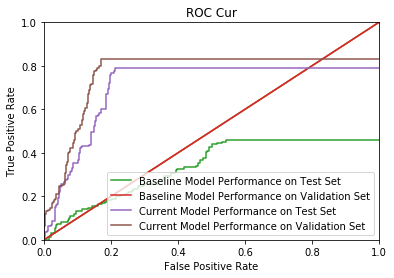

In [301]:
import matplotlib.pyplot as plt

#generate 50/50 plot for ROC
coin_flip_line = []
coin_flip_line.append(0)
coin_flip_line.append(.5)
coin_flip_line.append(1.0)

#generate ROC over test set
tpr_test,fpr_test = get_overall_tpr( (results_dir + generated_test), (results_dir + ground_truth_test) )
#generate ROC over validation set
tpr_valid, fpr_valid = get_overall_tpr( (results_dir + generated_validation), (results_dir + ground_truth_validation) )
#generate ROC for bl over test
bl_tpr_test, bl_fpr_test = get_overall_tpr( (results_dir + baseline_test), (results_dir + ground_truth_test) )
#generate ROC for bl over validation
bl_tpr_valid, bl_fpr_valid = get_overall_tpr( (results_dir + baseline_validation), (results_dir + ground_truth_validation) )


#saturate last value so it extends the graph

#baseline test
bl_fpr_test.append(1.0)
bl_tpr_test.append(max(bl_tpr_test))

#current test
fpr_test.append(1.0)
tpr_test.append(max(tpr_test))

#baseline valid
bl_fpr_valid.append(1.0)
bl_tpr_valid.append(max(bl_tpr_valid))

#current valid
fpr_valid.append(1.0)
tpr_valid.append(max(tpr_valid))

#plot roc curves
plt.plot(coin_flip_line, coin_flip_line)
bl_test_plot = plt.plot(bl_fpr_test, bl_tpr_test, label='Baseline Model Performance on Test Set')
bl_validation_plot = plt.plot(bl_fpr_valid, bl_fpr_valid, label='Baseline Model Performance on Validation Set')
test_plot = plt.plot(fpr_test, tpr_test, label='Current Model Performance on Test Set')
validation_plot = plt.plot(fpr_valid, tpr_valid, label='Current Model Performance on Validation Set')

#set up graph
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Cur')
plt.legend(loc="lower right")
plt.show()